# Fully Convolutional Interior/Edge Segmentation for 2D Data

---

Classifies each pixel as either Cell Edge, Cell Interior, or Background.

There are 2 different Cell Edge classes (Cell-Cell Boundary and Cell-Background Boundary)

In [1]:
import xarray as xr
import numpy as np
import os
import errno
import deepcell
from deepcell import model_zoo

### Load the training data

In [2]:
# create folder for this set of experiments
experiment_folder = "20200227_IF_Training"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [3]:
npz_name = "20200310_IF_Training_1"
training_data = np.load(NPZ_DIR + npz_name +".npz")
(X_train, y_train) = training_data["X"], training_data["y"]

print('X_train.shape: {}\ny_train.shape: {}'.format(X_train.shape, y_train.shape))

X_train.shape: (694, 256, 256, 2)
y_train.shape: (694, 256, 256, 1)


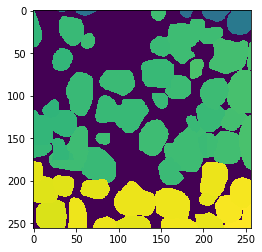

In [5]:
import matplotlib.pyplot as plt
plt.imshow(y_train[300, :, :, 0])

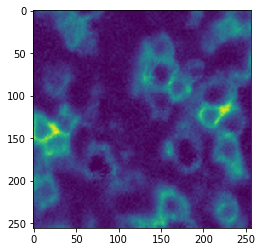

In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[300, :, :, 1])

### Set up filepath constants

In [8]:
# the path to the data file is currently required for `train_model_()` functions
DATA_FILE = os.path.join(NPZ_DIR, npz_name + ".npz")

# confirm the data file is available
assert os.path.isfile(DATA_FILE)

### Set up training parameters

In [9]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler


n_epoch = 10 # Number of training epochs
norm_method = 'std'  # data normalization
receptive_field = 61  # should be adjusted for the scale of the data
n_conv_filters = 128
n_dense_filters = 512

conv_model_name = npz_name + '_convolutional_{}_rf_{}_dense_{}_conv'.format(receptive_field, n_dense_filters, n_conv_filters)

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)
test_size = 0.05
seed=0

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'pixelwise'
dilation_radius = 1  # change dilation radius for edge dilation
separate_edge_classes = False  # break edges into cell-background edge, cell-cell edge
n_features = 4 if separate_edge_classes else 3

### Create a model for the edge/interior segmentation

#### Instantiate the segmentation transform model

In [10]:
conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=n_conv_filters,
    n_dense_filters=n_dense_filters,
    last_only=False,
    input_shape=tuple(X_train.shape[1:]))

W0311 01:03:49.979603 140472725989184 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
conv_model_name

'20200310_IF_Training_1_convolutional_61_rf_512_dense_128_conv'

#### Train the segmentation transform model

In [ ]:
from deepcell.training import train_model_conv

conv_model = train_model_conv(
    model=conv_model,
    dataset=DATA_FILE,  # full path to npz file
    model_name=conv_model_name,
    test_size=test_size,
    seed=seed,
    transform=transform,
    dilation_radius=dilation_radius,
    separate_edge_classes=separate_edge_classes,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    log_dir=LOG_DIR,
    model_dir=MODEL_DIR,
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False,
    zoom_range=(0.8, 1.2),)

X_train shape: (659, 256, 256, 2)
y_train shape: (659, 256, 256, 1)
X_test shape: (35, 256, 256, 2)
y_test shape: (35, 256, 256, 1)
Output Shape: (None, 256, 256, 3)
Number of Classes: 3
Training on 1 GPUs
Epoch 1/10


W0311 01:05:22.980690 140472725989184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


  1/659 [..............................] - ETA: 5:40:31 - loss: 5.5657 - model_loss: 1.3037 - model_1_loss: 1.3530 - model_2_loss: 1.3413 - model_3_loss: 1.4241 - model_acc: 0.4391 - model_1_acc: 0.3938 - model_2_acc: 0.2508 - model_3_acc: 0.4993

W0311 01:05:54.073505 140472725989184 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (0.599128). Check your callbacks.


228/659 [=========>....................] - ETA: 3:47 - loss: 3.7590 - model_loss: 0.8942 - model_1_loss: 0.8746 - model_2_loss: 0.9404 - model_3_loss: 0.9060 - model_acc: 0.6217 - model_1_acc: 0.6308 - model_2_acc: 0.6110 - model_3_acc: 0.6194

### Run the model

#### Make predictions on test data

In [18]:
#test_data = np.load(NPZ_DIR + "lab_combined_h3_test.npz")
test_data = np.load('/data/npz_data/TA489_Point8_Noisy_Cell.npz')
(X_test, y_test) = test_data["X"], test_data["y"]

In [31]:
weights_path = '/data/models/20200227_IF_Training/Training_Freeze_1_Val_Noisy_256x256_stride_0.5_convolutional_61_rf_512_dense_128_conv.h5'

In [ ]:
weights_path = os.path.join(MODEL_DIR, conv_model_name + ".h5")

In [32]:
run_conv_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=None,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=n_features,
    norm_method=norm_method,
    n_conv_filters=128,
    n_dense_filters=512,
    last_only=False,
    input_shape=tuple(X_test.shape[1:]))

run_conv_model.load_weights(weights_path)

In [33]:
test_images_conv = run_conv_model.predict(X_test[0:1, :, :, :])[-1]

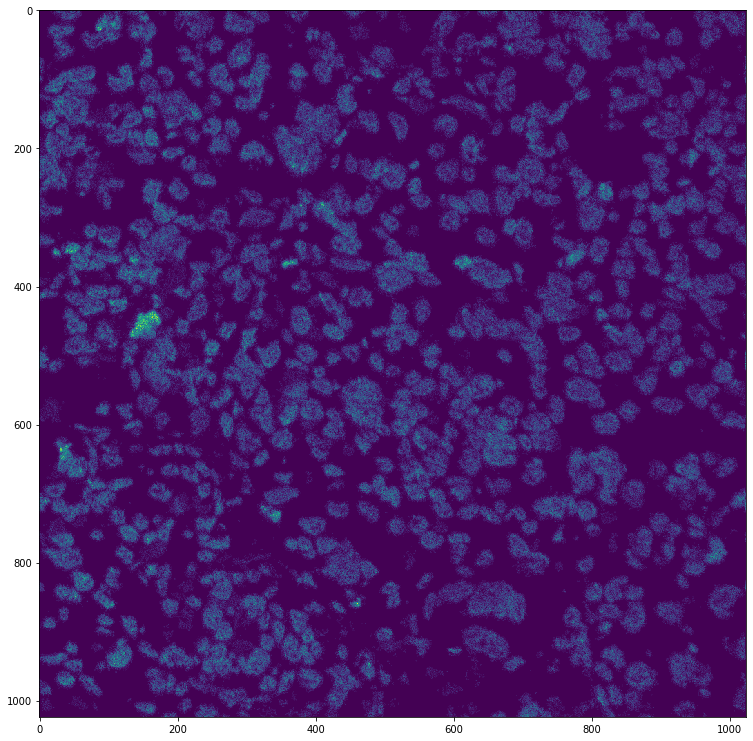

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(X_test[0, :, :, 0])

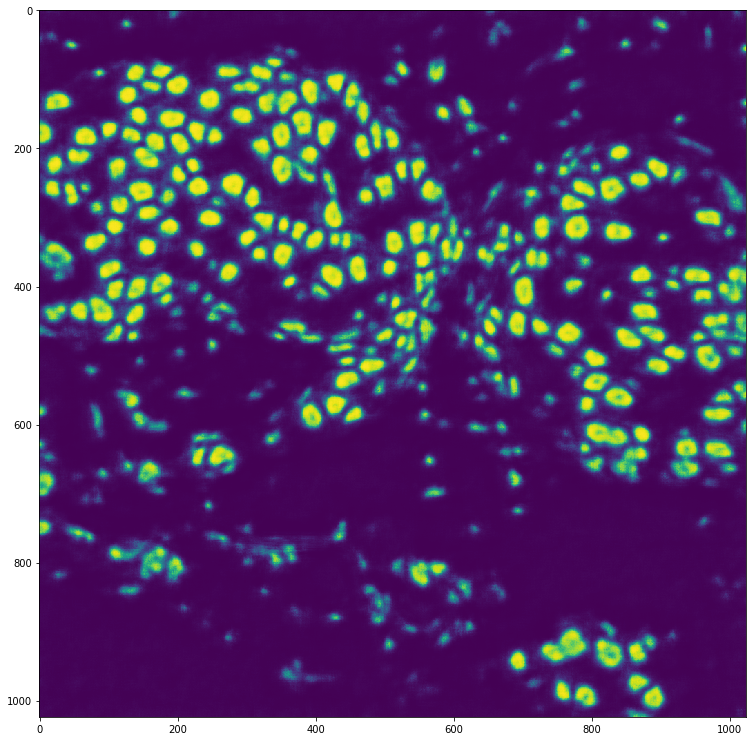

In [21]:
# IF_Training_1
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(test_images_conv[0, :, :, 1])

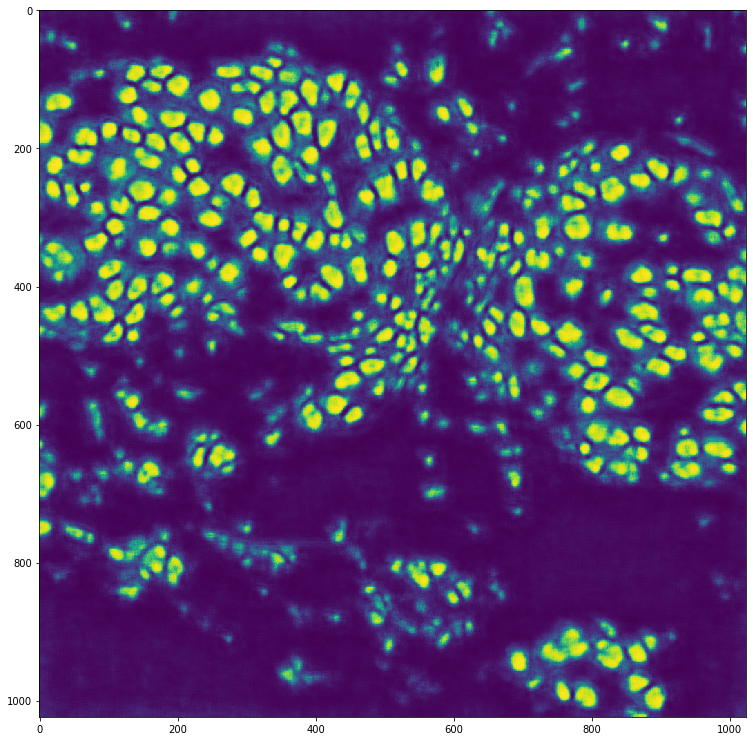

In [34]:
# Training_Freeze_1_Val_Noisy
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(test_images_conv[0, :, :, 1])

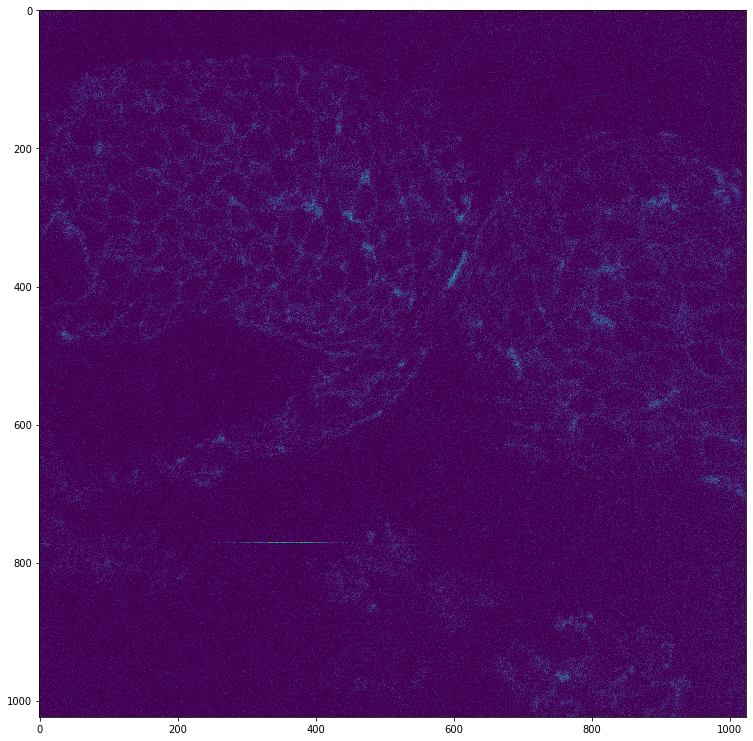

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(X_test[0, :, :, 1])